In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

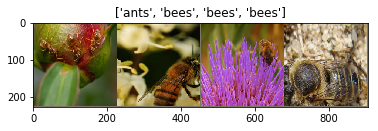

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval() #Set the model to evaluate and not training
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']): #load dataloader 
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
def compute_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in  dataloaders['val']:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [10]:
#FINETUNING
### RETRAIN **ALL** THE NETWORK PARAMS          -------->
                                             #          |
model_ft = models.resnet18(pretrained=True)  #          |
num_ftrs = model_ft.fc.in_features           #          |
model_ft.fc = nn.Linear(num_ftrs, 2)         #          |
                                             #          |
model_ft = model_ft.to(device)               #          |
                                             #          |
criterion = nn.CrossEntropyLoss()            #          |
                                             #          |
# Observe that all parameters are being optimized   <----
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


###tranin the model####
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

#visualize 
visualize_model(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/fcdl/.torch/models/resnet18-5c106cde.pth
100.0%


Epoch 0/24
----------


Process Process-8:
Process Process-6:
Process Process-7:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/fcdl/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/fcdl/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/fcdl/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/fcdl/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/fcdl/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fcdl/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/fcdl/miniconda3/lib/python3.6/multiprocessing/proces

KeyboardInterrupt: 

Epoch 0/24
----------
train Loss: 0.5809 Acc: 0.6844
val Loss: 0.2786 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4837 Acc: 0.7869
val Loss: 0.2803 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4157 Acc: 0.8033
val Loss: 0.3649 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.3893 Acc: 0.8115
val Loss: 0.2770 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5462 Acc: 0.7828
val Loss: 0.2210 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3632 Acc: 0.8525
val Loss: 0.1847 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5103 Acc: 0.8074
val Loss: 0.2085 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3227 Acc: 0.8566
val Loss: 0.1960 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3644 Acc: 0.8402
val Loss: 0.1831 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3872 Acc: 0.8443
val Loss: 0.1859 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3162 Acc: 0.8607
val Loss: 0.1839 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3463 Acc: 0.8566
val Loss: 0.1790 Acc: 0.9542

Ep

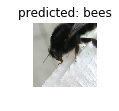

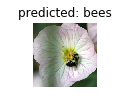

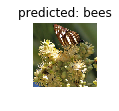

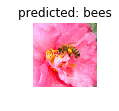

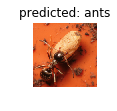

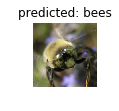

In [6]:
#ConvNet as feature extractor
### **DON'T** RETRAIN ALL THE NETWORK PARAMS 
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False ##set for not computing the gradient and so not updating the model

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

###tranin the model####
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

#visualize 
visualize_model(model_conv)


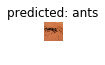

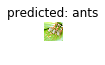

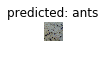

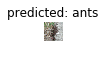

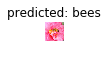

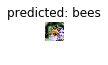

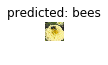

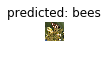

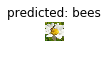

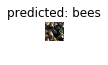

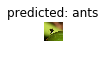

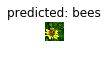

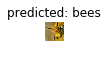

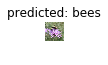

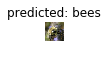

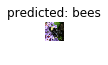

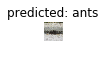

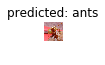

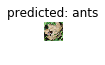

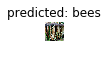

In [7]:
#visualize 
visualize_model(model_conv, 20)

In [8]:
##Save the model after training it (you'll loose time otherwise, badass)
torch.save(model_conv.state_dict(), "model_TL")

In [10]:
model_conv_load = torchvision.models.resnet18(pretrained=True)
for param in model_conv_load.parameters():
    param.requires_grad = False ##set for not computing the gradient and so not updating the model

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs_load = model_conv_load.fc.in_features
model_conv_load.fc = nn.Linear(num_ftrs, 2)
model_conv_load.load_state_dict(torch.load("model_TL"))

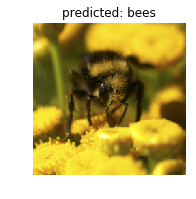

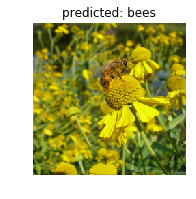

In [11]:
#visualize 
visualize_model(model_conv_load, 2)

In [24]:
acc = compute_accuracy(model_conv)
acc_load= compute_accuracy(model_conv_load)
print('Accuracy of the network on the test images: %d %%' % (acc))
print('Accuracy of the network on the test images: %d %%' % (acc_load))

Accuracy of the network on the test images: 44 %
Accuracy of the network on the test images: 84 %
